In [1]:
# Imports
#---------

import pandas as pd
import os
import numpy as np
import datetime as dt
import pyreadr
import wget
import requests
from urllib.error import HTTPError
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

aurn_path = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/aurn_2016_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'



In [2]:
# Load datasets
#---------------

oxford_auto_20102021_1hr = pd.read_csv(aurn_path+'oxford_auto_20102021_1hr.csv.gz')
oxford_auto_20102021_1hr['date'] = pd.to_datetime(oxford_auto_20102021_1hr['date'],utc=True)
oxford_auto_20102021_1hr.set_index(['date','site','code'], inplace=True)
oxford_auto_20102021_1hr

,,,NO2,NOXasNO2,NO,PM10,PM2.5,temp,ws,wd,location_type,latitude,longitude
date,site,code,,,,,,,,,,,
2021-01-01 00:00:00+00:00,Oxford Centre Roadside,OX,27.31117,37.73183,6.79618,NaN,NaN,-2.6,1.9,304.1,Urban Traffic,51.751745,-1.257463
2021-01-01 01:00:00+00:00,Oxford Centre Roadside,OX,24.71520,28.89673,2.72713,NaN,NaN,-3.0,2.1,292.3,Urban Traffic,51.751745,-1.257463
2021-01-01 02:00:00+00:00,Oxford Centre Roadside,OX,23.32310,30.98926,4.99974,NaN,NaN,-3.3,2.3,288.4,Urban Traffic,51.751745,-1.257463
2021-01-01 03:00:00+00:00,Oxford Centre Roadside,OX,21.67781,27.95012,4.09069,NaN,NaN,-3.5,2.3,288.4,Urban Traffic,51.751745,-1.257463
2021-01-01 04:00:00+00:00,Oxford Centre Roadside,OX,21.27894,27.20279,3.86343,NaN,NaN,-3.6,2.2,299.0,Urban Traffic,51.751745,-1.257463
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00+00:00,Oxford High St,OX6,28.68750,49.72500,13.72030,24.0,NaN,NaN,NaN,NaN,Urban traffic,51.752527,-1.250939
2014-12-31 20:00:00+00:00,Oxford High St,OX6,21.03750,32.51250,7.48380,30.2,NaN,NaN,NaN,NaN,Urban traffic,51.752527,-1.250939
2014-12-31 21:00:00+00:00,Oxford High St,OX6,24.86250,42.07500,11.22570,27.0,NaN,NaN,NaN,NaN,Urban traffic,51.752527,-1.250939


In [3]:
sebbes_1019 = oxford_auto_20102021_1hr.query('code == "OX8"')
df0 = sebbes_1019.reset_index(['site','code']).resample('24H').mean()
df1 = sebbes_1019.reset_index(['site','code'])[['PM10']].resample('24H').quantile(q=0.99).rename(columns={'PM10':'PM10p99'})
df2 = sebbes_1019.reset_index(['site','code'])[['PM2.5']].resample('24H').quantile(q=0.99).rename(columns={'PM2.5':'PM25p99'})
sebbes_1019_24hmean = pd.concat([df0,df1,df2], axis=1)
sebbes_1019_24hmean

sebbes_1019_24hmean['PM10_lowess'] = sm.nonparametric.lowess(exog=sebbes_1019_24hmean.index, 
                                                             endog=sebbes_1019_24hmean['PM10'], 
                                                             frac=.1, 
                                                             it=2, 
                                                             return_sorted=False)
x = sebbes_1019_24hmean.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_1019_24hmean.dropna()['PM10'].values
ols_fit = sm.OLS(exog=x, endog=y).fit()
pm10_ols = ols_fit.predict(x)

sebbes_1019_24hmean['PM10p99_lowess'] = sm.nonparametric.lowess(exog=sebbes_1019_24hmean.index, 
                                                   endog=sebbes_1019_24hmean['PM10p99'], 
                                                   frac=.1, 
                                                   it=2, 
                                                   return_sorted=False)

x = sebbes_1019_24hmean.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_1019_24hmean.dropna()['PM10p99'].values

ols_fit = sm.OLS(exog=x, endog=y).fit()
pm10p99_ols_y = ols_fit.predict(x)

sebbes = oxford_auto_20102021_1hr.query('code == "OX8"')['PM10']
sebbes_m = sebbes.reset_index(['site','code']).resample('M').mean()
x = sebbes_m.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_m.dropna()['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)
ols_fit = sm.OLS(exog=x, endog=y).fit()
sebbes_pm10monthly_ols_y = ols_fit.predict(x)

# highs = oxford_auto_20102021_1hr.query('code == "OX6"')['PM10']
# highs_m = highs.reset_index(['site','code']).resample('M').mean()
# x = highs_m.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
# y = highs_m.dropna()['PM10'].values
# ols_fit = sm.OLS(exog=x, endog=y).fit()
# highs_pm10monthly_ols_y = ols_fit.predict(x)

In [4]:
highs_1019 = oxford_auto_20102021_1hr.query('code == "OX6"')
df0 = highs_1019.reset_index(['site','code']).resample('24H').mean()
df1 = highs_1019.reset_index(['site','code'])[['PM10']].resample('24H').quantile(q=0.99).rename(columns={'PM10':'PM10p99'})
df2 = highs_1019.reset_index(['site','code'])[['PM2.5']].resample('24H').quantile(q=0.99).rename(columns={'PM2.5':'PM25p99'})
highs_1019_24hmean = pd.concat([df0,df1,df2], axis=1)
highs_1019_24hmean

highs_1019_24hmean['PM10_lowess'] = sm.nonparametric.lowess(exog=highs_1019_24hmean.index, 
                                                             endog=highs_1019_24hmean['PM10'], 
                                                             frac=.1, 
                                                             it=2, 
                                                             return_sorted=False)
x = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['date'].apply(lambda x: x.toordinal()).values
y = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['PM10'].values
ols_fit = sm.OLS(exog=x, endog=y).fit()
pm10_ols = ols_fit.predict(x)

highs_1019_24hmean['PM10p99_lowess'] = sm.nonparametric.lowess(exog=highs_1019_24hmean.index, 
                                                   endog=highs_1019_24hmean['PM10p99'], 
                                                   frac=.1, 
                                                   it=2, 
                                                   return_sorted=False)

x = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['date'].apply(lambda x: x.toordinal()).values
y = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['PM10p99'].values
ols_fit = sm.OLS(exog=x, endog=y).fit()
pm10p99_ols_y = ols_fit.predict(x)

highs = oxford_auto_20102021_1hr.query('code == "OX6"')['PM10']
highs_m = highs.reset_index(['site','code']).resample('M').mean()
x = highs_m.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = highs_m.dropna()['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)
ols_fit = sm.OLS(exog=x, endog=y).fit()
highs_pm10monthly_ols_y = ols_fit.predict(x)

# highs = oxford_auto_20102021_1hr.query('code == "OX6"')['PM10']
# highs_m = highs.reset_index(['site','code']).resample('M').mean()
# x = highs_m.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
# y = highs_m.dropna()['PM10'].values
# ols_fit = sm.OLS(exog=x, endog=y).fit()
# highs_pm10monthly_ols_y = ols_fit.predict(x)

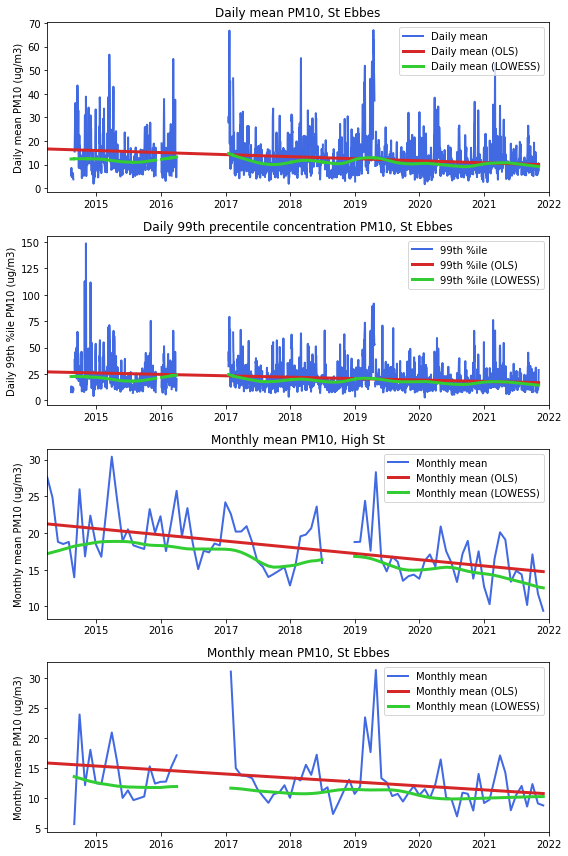

In [5]:
# Calc stats for St Ebbes & High St daily & monthly means & p99
#---------------------------------------------------------------

sebbes_1019_24hmean['PM10_lowess'] = sm.nonparametric.lowess(exog=sebbes_1019_24hmean.index, 
                                                             endog=sebbes_1019_24hmean['PM10'], 
                                                             frac=.1, 
                                                             it=2, 
                                                             return_sorted=False)
xdate_24h = sebbes_1019_24hmean.reset_index().dropna()['date'].values
x = sebbes_1019_24hmean.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_1019_24hmean.dropna()['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_24h = regr.predict(x)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

#################

sebbes_1019_24hmean['PM10p99_lowess'] = sm.nonparametric.lowess(exog=sebbes_1019_24hmean.index, 
                                                   endog=sebbes_1019_24hmean['PM10p99'], 
                                                   frac=.1, 
                                                   it=2, 
                                                   return_sorted=False)
xdate_p99 = sebbes_1019_24hmean.reset_index().dropna()['date'].values
x = sebbes_1019_24hmean.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_1019_24hmean.dropna()['PM10p99'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_p99 = regr.predict(x)
# print(len(y_pred))

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

#############
highs = oxford_auto_20102021_1hr.query('code == "OX6"').dropna(subset=['PM10'])
highs['PM10_lowess'] = sm.nonparametric.lowess(exog=highs.index.get_level_values(0), 
                                                   endog=highs['PM10'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
highs_m = highs.reset_index(['site','code']).resample('M').mean()
xdate_highs = highs_m.reset_index().dropna(subset=['PM10'])['date'].values
x = highs_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
y = highs_m.dropna(subset=['PM10'])['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_highs = regr.predict(x)

#############
sebbes = oxford_auto_20102021_1hr.query('code == "OX8"').dropna(subset=['PM10'])
sebbes['PM10_lowess'] = sm.nonparametric.lowess(exog=sebbes.index.get_level_values(0), 
                                                   endog=sebbes['PM10'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
sebbes_m = sebbes.reset_index(['site','code']).resample('M').mean()
xdate_sebbes = sebbes_m.reset_index().dropna(subset=['PM10'])['date']
x = sebbes_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
y = sebbes_m.dropna(subset=['PM10'])['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_sebbes = regr.predict(x)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

# Plot outputs
minx = pd.to_datetime('2014-04-01')
maxx = pd.to_datetime('2022-01-01')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,12), sharex=False)

ax1.plot('PM10', data=sebbes_1019_24hmean, c='royalblue', lw=2, label='Daily mean')
ax1.plot(xdate_24h, y_pred_24h, color="tab:red", lw=3, label='Daily mean (OLS)')
ax1.plot('PM10_lowess',data=sebbes_1019_24hmean, lw=3, c='limegreen', label='Daily mean (LOWESS)')
ax2.plot('PM10p99', data=sebbes_1019_24hmean, c='royalblue', lw=2, label='99th %ile')
ax2.plot(xdate_p99, y_pred_p99, color="tab:red", lw=3, label='99th %ile (OLS)')
ax2.plot('PM10p99_lowess',data=sebbes_1019_24hmean, lw=3, c='limegreen', label='99th %ile (LOWESS)')
ax3.plot('PM10', data=highs_m, c='royalblue', lw=2, label='Monthly mean')
ax3.plot(xdate_highs, y_pred_highs, color="tab:red", lw=3, label='Monthly mean (OLS)')
ax3.plot('PM10_lowess',data=highs_m, lw=3, c='limegreen', label='Monthly mean (LOWESS)')
ax4.plot('PM10', data=sebbes_m, c='royalblue', lw=2, label='Monthly mean')
ax4.plot(xdate_sebbes, y_pred_sebbes, color="tab:red", lw=3, label='Monthly mean (OLS)')
ax4.plot('PM10_lowess',data=sebbes_m, lw=3, c='limegreen', label='Monthly mean (LOWESS)')

ax1.set_xlim(minx, maxx)
ax2.set_xlim(minx, maxx)
ax3.set_xlim(minx, maxx)
ax4.set_xlim(minx, maxx)

ax1.set_title('Daily mean PM10, St Ebbes')
ax2.set_title('Daily 99th precentile concentration PM10, St Ebbes')
ax3.set_title('Monthly mean PM10, High St')
ax4.set_title('Monthly mean PM10, St Ebbes')

ax1.set_ylabel('Daily mean PM10 (ug/m3)')
ax2.set_ylabel('Daily 99th %ile PM10 (ug/m3)')
ax3.set_ylabel('Monthly mean PM10 (ug/m3)')
ax4.set_ylabel('Monthly mean PM10 (ug/m3)')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [6]:
# Calc stats for St Ebbes & High St daily & monthly means
#---------------------------------------------------------

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

sebbes_1019_24hmean['PM10_lowess'] = sm.nonparametric.lowess(exog=sebbes_1019_24hmean.index, 
                                                             endog=sebbes_1019_24hmean['PM10'], 
                                                             frac=.1, 
                                                             it=2, 
                                                             return_sorted=False)
xdate_24hs = sebbes_1019_24hmean.reset_index().dropna()['date'].values
x = sebbes_1019_24hmean.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_1019_24hmean.dropna()['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_24hs = regr.predict(x)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

#################

highs_1019_24hmean['PM10_lowess'] = sm.nonparametric.lowess(exog=highs_1019_24hmean.index, 
                                                   endog=highs_1019_24hmean['PM10'], 
                                                   frac=.1, 
                                                   it=2, 
                                                   return_sorted=False)
xdate_24hh = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['date'].values
x = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['date'].apply(lambda x: x.toordinal()).values
y = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_24hh = regr.predict(x)
# print(len(y_pred))

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

#############
highs = oxford_auto_20102021_1hr.query('code == "OX6"').dropna(subset=['PM10'])
highs['PM10_lowess'] = sm.nonparametric.lowess(exog=highs.index.get_level_values(0), 
                                                   endog=highs['PM10'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
highs_m = highs.reset_index(['site','code']).resample('M').mean()
xdate_highs = highs_m.reset_index().dropna(subset=['PM10'])['date'].values
x = highs_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
y = highs_m.dropna(subset=['PM10'])['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_highs = regr.predict(x)

#############
sebbes = oxford_auto_20102021_1hr.query('code == "OX8"').dropna(subset=['PM10'])
sebbes['PM10_lowess'] = sm.nonparametric.lowess(exog=sebbes.index.get_level_values(0), 
                                                   endog=sebbes['PM10'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
sebbes_m = sebbes.reset_index(['site','code']).resample('M').mean()
xdate_sebbes = sebbes_m.reset_index().dropna(subset=['PM10'])['date']
x = sebbes_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
y = sebbes_m.dropna(subset=['PM10'])['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_sebbes = regr.predict(x)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

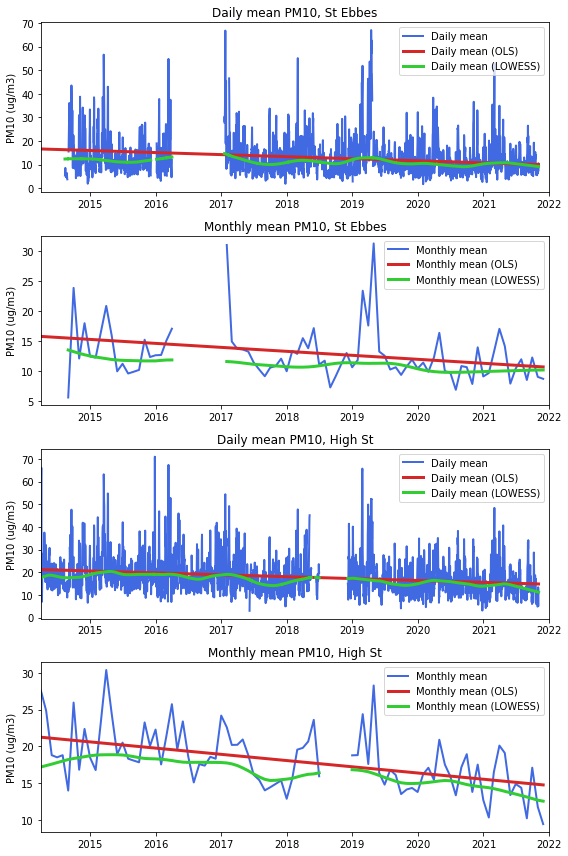

In [7]:
# Plot St Ebbes & High St daily & monthly means
#-----------------------------------------------

minx = pd.to_datetime('2014-04-01')
maxx = pd.to_datetime('2022-01-01')

fig, (ax1, ax4, ax2, ax3) = plt.subplots(4,1, figsize=(8,12), sharex=False)

ax1.plot('PM10', data=sebbes_1019_24hmean, c='royalblue', lw=2, label='Daily mean')
ax1.plot(xdate_24hs, y_pred_24hs, color="tab:red", lw=3, label='Daily mean (OLS)')
ax1.plot('PM10_lowess',data=sebbes_1019_24hmean, lw=3, c='limegreen', label='Daily mean (LOWESS)')
ax2.plot('PM10', data=highs_1019_24hmean, c='royalblue', lw=2, label='Daily mean')
ax2.plot(xdate_24hh, y_pred_24hh, color="tab:red", lw=3, label='Daily mean (OLS)')
ax2.plot('PM10_lowess',data=highs_1019_24hmean, lw=3, c='limegreen', label='Daily mean (LOWESS)')
ax3.plot('PM10', data=highs_m, c='royalblue', lw=2, label='Monthly mean')
ax3.plot(xdate_highs, y_pred_highs, color="tab:red", lw=3, label='Monthly mean (OLS)')
ax3.plot('PM10_lowess',data=highs_m, lw=3, c='limegreen', label='Monthly mean (LOWESS)')
ax4.plot('PM10', data=sebbes_m, c='royalblue', lw=2, label='Monthly mean')
ax4.plot(xdate_sebbes, y_pred_sebbes, color="tab:red", lw=3, label='Monthly mean (OLS)')
ax4.plot('PM10_lowess',data=sebbes_m, lw=3, c='limegreen', label='Monthly mean (LOWESS)')

ax1.set_xlim(minx, maxx)
ax2.set_xlim(minx, maxx)
ax3.set_xlim(minx, maxx)
ax4.set_xlim(minx, maxx)

ax1.set_title('Daily mean PM10, St Ebbes')
ax2.set_title('Daily mean PM10, High St')
ax3.set_title('Monthly mean PM10, High St')
ax4.set_title('Monthly mean PM10, St Ebbes')

ax1.set_ylabel('PM10 (ug/m3)')
ax2.set_ylabel('PM10 (ug/m3)')
ax3.set_ylabel('PM10 (ug/m3)')
ax4.set_ylabel('PM10 (ug/m3)')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.savefig(stats_home+'daily_monthly_mean_pm10_ts_2015_2022.png')

plt.show()

In [8]:
# Calc stats for St Ebbes & High St daily & monthly means
#---------------------------------------------------------

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

sebbes_1019_24hmean['PM25_lowess'] = sm.nonparametric.lowess(exog=sebbes_1019_24hmean.index, 
                                                             endog=sebbes_1019_24hmean['PM2.5'], 
                                                             frac=.1, 
                                                             it=2, 
                                                             return_sorted=False)
xdate_24hs = sebbes_1019_24hmean.reset_index().dropna()['date'].values
x = sebbes_1019_24hmean.reset_index().dropna()['date'].apply(lambda x: x.toordinal()).values
y = sebbes_1019_24hmean.dropna()['PM2.5'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_24hs = regr.predict(x)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

#################

highs_1019_24hmean['PM25_lowess'] = sm.nonparametric.lowess(exog=highs_1019_24hmean.index, 
                                                   endog=highs_1019_24hmean['PM10'], 
                                                   frac=.1, 
                                                   it=2, 
                                                   return_sorted=False)
xdate_24hh = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['date'].values
x = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['date'].apply(lambda x: x.toordinal()).values
y = highs_1019_24hmean.reset_index().loc[:,['date','NO2','NOXasNO2','NO','PM10','PM10p99','PM10_lowess']].dropna()['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_24hh = regr.predict(x)
# print(len(y_pred))

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

#############
highs = oxford_auto_20102021_1hr.query('code == "OX6"').dropna(subset=['PM10'])
highs['PM10_lowess'] = sm.nonparametric.lowess(exog=highs.index.get_level_values(0), 
                                                   endog=highs['PM10'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
highs_m = highs.reset_index(['site','code']).resample('M').mean()
xdate_highs = highs_m.reset_index().dropna(subset=['PM10'])['date'].values
x = highs_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
y = highs_m.dropna(subset=['PM10'])['PM10'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

# Make predictions using the testing set
y_pred_highs = regr.predict(x)

#############
sebbes = oxford_auto_20102021_1hr.query('code == "OX8"').dropna(subset=['PM10','PM2.5'])
sebbes['PM10_lowess'] = sm.nonparametric.lowess(exog=sebbes.index.get_level_values(0), 
                                                   endog=sebbes['PM10'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
sebbes['PM25_lowess'] = sm.nonparametric.lowess(exog=sebbes.index.get_level_values(0), 
                                                   endog=sebbes['PM2.5'].values, 
                                                   frac=.2, 
                                                   it=2, 
                                                   return_sorted=False)
sebbes_m = sebbes.reset_index(['site','code']).resample('M').mean()
xdate_sebbes = sebbes_m.reset_index().dropna(subset=['PM10'])['date']
x = sebbes_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
y10 = sebbes_m.dropna(subset=['PM10','PM2.5'])['PM10'].values
y25 = sebbes_m.dropna(subset=['PM10','PM2.5'])['PM2.5'].values
x = x.reshape(-1,1)
y10 = y10.reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(x, y10)

# Make predictions using the testing set
y10_pred_sebbes = regr.predict(x)

y25 = y25.reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(x, y25)

# Make predictions using the testing set
y25_pred_sebbes = regr.predict(x)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

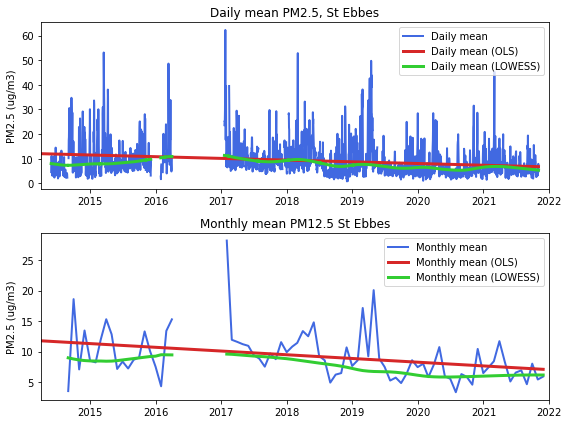

In [9]:
# Plot St Ebbes & High St daily & monthly means
#-----------------------------------------------

minx = pd.to_datetime('2014-04-01')
maxx = pd.to_datetime('2022-01-01')

fig, (ax1,ax4) = plt.subplots(2,1, figsize=(8,6), sharex=False)

ax1.plot('PM2.5', data=sebbes_1019_24hmean, c='royalblue', lw=2, label='Daily mean')
ax1.plot(xdate_24hs, y_pred_24hs, color="tab:red", lw=3, label='Daily mean (OLS)')
ax1.plot('PM25_lowess',data=sebbes_1019_24hmean, lw=3, c='limegreen', label='Daily mean (LOWESS)')

ax4.plot('PM2.5', data=sebbes_m, c='royalblue', lw=2, label='Monthly mean')
ax4.plot(xdate_sebbes, y25_pred_sebbes, color="tab:red", lw=3, label='Monthly mean (OLS)')
ax4.plot('PM25_lowess',data=sebbes_m, lw=3, c='limegreen', label='Monthly mean (LOWESS)')

ax1.set_xlim(minx, maxx)

ax4.set_xlim(minx, maxx)

ax1.set_title('Daily mean PM2.5, St Ebbes')

ax4.set_title('Monthly mean PM12.5 St Ebbes')

ax1.set_ylabel('PM2.5 (ug/m3)')
ax4.set_ylabel('PM2.5 (ug/m3)')

ax1.legend(loc='upper right')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.savefig(stats_home+'daily_monthly_mean_pm25_ts_2015_2022.png')

plt.show()

In [10]:
# Calc stats for St Ebbes & High St daily & monthly means
#---------------------------------------------------------

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
#############
highs = oxford_auto_20102021_1hr.query('code == "OX6"').dropna(subset=['PM10'])
highs_m = highs.reset_index(['site','code']).resample('M').mean()
xdate_highs = highs_m.reset_index().dropna(subset=['PM10'])['date'].values
hx = highs_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
hy = highs_m.dropna(subset=['PM10'])['PM10'].values
hx = hx.reshape(-1,1)
hy = hy.reshape(-1,1)

regr = linear_model.LinearRegression()

regr.fit(hx, hy)

# Make predictions using the testing set
y_pred_highs = regr.predict(hx)

#############
sebbes = oxford_auto_20102021_1hr.query('code == "OX8"').dropna(subset=['PM10','PM2.5'])
sebbes_m = sebbes.reset_index(['site','code']).resample('M').mean()
xdate_sebbes = sebbes_m.reset_index().dropna(subset=['PM10'])['date']
sx = sebbes_m.reset_index().dropna(subset=['PM10'])['date'].apply(lambda x: x.toordinal()).values
sy10 = sebbes_m.dropna(subset=['PM10','PM2.5'])['PM10'].values
sy25 = sebbes_m.dropna(subset=['PM10','PM2.5'])['PM2.5'].values
sx = sx.reshape(-1,1)
sy10 = sy10.reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(sx, sy10)

# Make predictions using the testing set
y10_pred_sebbes = regr.predict(sx)

sy25 = sy25.reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(sx, sy25)

# Make predictions using the testing set
y25_pred_sebbes = regr.predict(sx)



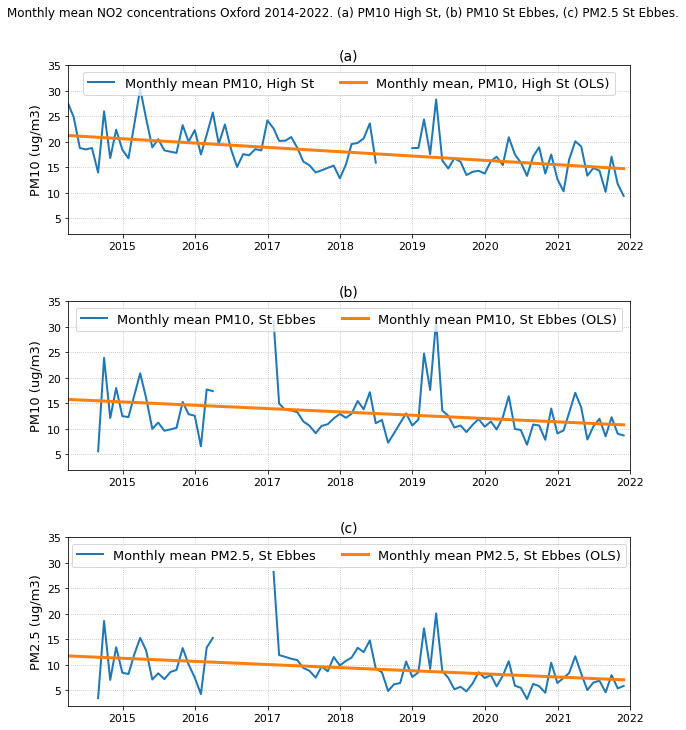

In [14]:
# Plot St Ebbes & High St daily & monthly means
#-----------------------------------------------

minx = pd.to_datetime('2014-04-01')
maxx = pd.to_datetime('2022-01-01')

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9,10), sharex=False)

ax1.plot('PM10', data=highs_m, c='tab:blue', lw=2, label='Monthly mean PM10, High St')
ax1.plot(xdate_highs, y_pred_highs, color="tab:orange", lw=3, label='Monthly mean, PM10, High St (OLS)')
ax2.plot('PM10', data=sebbes_m, c='tab:blue', lw=2, label='Monthly mean PM10, St Ebbes')
ax2.plot(xdate_sebbes, y10_pred_sebbes, color="tab:orange", lw=3, label='Monthly mean PM10, St Ebbes (OLS)')
ax3.plot('PM2.5', data=sebbes_m, c='tab:blue', lw=2, label='Monthly mean PM2.5, St Ebbes')
ax3.plot(xdate_sebbes, y25_pred_sebbes, color="tab:orange", lw=3, label='Monthly mean PM2.5, St Ebbes (OLS)')

ax1.set_xlim(minx, maxx)
ax2.set_xlim(minx, maxx)
ax3.set_xlim(minx, maxx)

ax1.set_title('(a)',fontsize=14)
ax2.set_title('(b)',fontsize=14)
ax3.set_title('(c)',fontsize=14)

ax1.set_ylabel('PM10 (ug/m3)',fontsize=13)
ax2.set_ylabel('PM10 (ug/m3)',fontsize=13)
ax3.set_ylabel('PM2.5 (ug/m3)',fontsize=13)

ax1.set_ylim(2,35)
ax2.set_ylim(2,35)
ax3.set_ylim(2,35)

ax1.tick_params(
    axis='both',
    labelsize=11,
)
ax2.tick_params(
    axis='both',
    labelsize=11,
)
ax3.tick_params(
    axis='both',
    labelsize=11,
)

ax1.legend(loc='upper center', ncol=2,fontsize=13)
ax2.legend(loc='upper center', ncol=2,fontsize=13)
ax3.legend(loc='upper center', ncol=2,fontsize=13)
ax1.grid(True, ls=':')
ax2.grid(True, ls=':')
ax3.grid(True, ls=':')

plt.suptitle('Monthly mean NO2 concentrations Oxford 2014-2022. (a) PM10 High St, (b) PM10 St Ebbes, (c) PM2.5 St Ebbes.', y=1.01)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig('monthly_mean_pm1025_ts_2014_2022.png')

plt.show()